In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode, lsim, lti
from scipy import signal
import control.matlab as control
from IPython.display import Math, display

# Zweipunkt Regler

In [2]:
class Regler2Pkt:
    def __init__(self, setPoint, hyst, minOut, maxOut):
        self.setPoint = setPoint
        self.hyst = hyst
        self.minOut = minOut
        self.maxOut = maxOut
        self.state = None
    
    def reset(self):
        self.state = None
    
    def regel(self, curValue):
        if self.state is None:
            if curValue > self.setPoint:
                self.state = True
            else:
                self.state = False
                
        if self.state == False and curValue > self.setPoint + self.hyst:
            self.state = True
        elif self.state == True and curValue < self.setPoint - self.hyst:
            self.state = False
        
        if self.state:
            out = self.minOut
        else:
            out = self.maxOut
            
        return out                    

## Strecke

In [3]:
class PT1Tt:
    def __init__(self, T, K, L, dt, x0):
        self.T = T
        self.K = K
        self.L = L
        self.dt = dt
        self.y = x0
        self.yHist = np.ones([int(L / dt)]) * x0
    
    def out(self, u):
        
        dtdy = 1 / self.T * (self.K * u - self.y)
        self.y += self.dt * dtdy
        self.yHist = np.concatenate((np.array([self.y]), self.yHist[0:-1]))
        #self.y = self.yHist[-1]
        
        return self.yHist[-1]
    
    def sim(self, u):
        yRes = []
        for idx, x in np.ndenumerate(u):
            y = self.out(x)
            yRes.append(y) 
        
        return yRes
    
    def reset(self, x0):
        self.y = x0
        self.yHist = np.ones([int(self.L / self.dt)]) * x0

In [36]:
T = 5
K = 2
L = 1
uMax = 1
dt = 0.1
strecke = PT1Tt(T, K, L, dt, 0)

In [37]:
t = np.linspace(0, 50, 501)
u = np.ones(t.size)

In [38]:
res = strecke.sim(u)

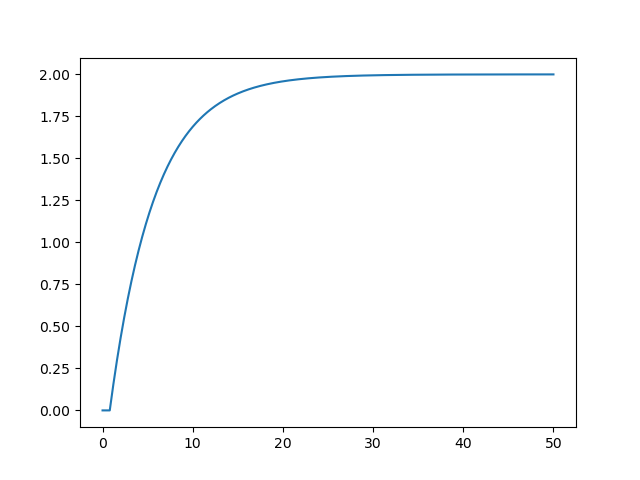

In [39]:
plt.figure()
plt.plot(t, res)

In [44]:
yR = 1
regler = Regler2Pkt(yR, 0, 0, 1)
strecke.reset(0)

In [45]:
yRes = [0]
uRes = []
strecke.reset(0)
regler.reset()
for idx, x in np.ndenumerate(t):
    u = regler.regel(yRes[-1])
    y = strecke.out(u)
    yRes.append(y)
    uRes.append(u)

In [46]:
t[[0,-1]]

array([ 0., 50.])

In [50]:
yE = uMax * K
y1 = yE - (yE - yR) * np.exp(-L / T)

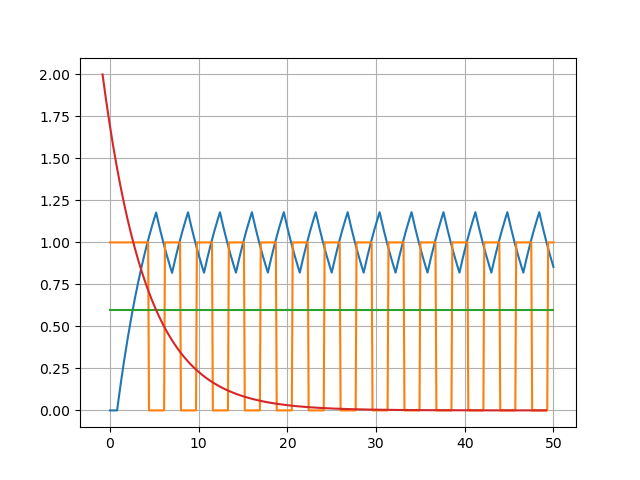

In [53]:
plt.figure()
plt.plot(t, yRes[1::])
plt.plot(t, uRes)
plt.plot(t[[0,-1]], np.array([0.6, 0.6]))
plt.plot(t - 0.84, 2 * np.exp(-t / 5))
plt.grid()